Look into the following pages to begin or find documentation on the python librairies used here:
- http://www.python.org
- http://scipy.org
- http://www.numpy.org
- http://scikit-learn.org/stable/index.html
- http://www.loria.fr/~rougier/teaching/matplotlib/matplotlib.html

## Introduction


In this lab session, we will work on a first practical application of supervised learning, which is arguably the simplest one: **binary supervised classification**. We will generate artificial data from two different sources, and we will try to learn a classifier that will be able to separate the data, using the **perceptron**. 

### Definitions and notations

- $\mathcal{X}$ is a set of *examples/observations/samples* $\mathbf{x} = (x_1, x_2, ..., x_p) \in \mathbb{R}^p$. We call $x_j$ the value taken by the $j$-th variable of $\mathbf{x}$, or its $j$-th *feature*.
- $\mathcal{Y}$ is the set of labels. We are in the **binary** case: there is only two possible labels. We choose to note them $\{ -1, 1\}$, which will make things easy by allowing us to work with the ```sign``` function.
- $\mathcal{D}_n = \{(x_i, y_i), i=1, .., n\}$ is a dataset containing $n$ examples and their labels. 
- There exists a probabilistic model governing the generation of our data given i.i.d random variables $X$ and $Y$: $\forall i \in \{ 1, ..., n \}, (x_i, y_i) \sim (X, Y)$
- We would like to build, from $\mathcal{D}_n$, a function that we call a *classifier*, $$\hat{f}: \mathcal{X} \rightarrow \{ -1, 1 \}$$ which for a new data point $\mathbf{x}_{new}$ will give a label $\hat{f}(\mathbf{x}_{new})$.

In [1]:
"""From a lab created on Mon Sep 23 17:50:04 2013 by baskiotis, salmon, gramfort
Modified on Mon Nov 4 21:09:38 2019 by mozharovskyi
Modified on Wed Feb 17 by labeau"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from matplotlib import rc

################################################################
# Code for displaying labeled data - no understanding needed ! #
################################################################

symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Generating artificial data 

For our first experiment, and in order to visualize what is happening, we will work with only two features (so, with $p=2$) so that we can plot the data and the classifier. 

1) Take a look at the function ```rand_gauss(n, mu, sigma)```: this function returns $n$ samples following the multi-dimensional normal distribution, with mean the vector $\mu =$ ```mu```, and with the covariance matrix $\Sigma$ being the diagonal matrix of the vector ```sigmas``` $=[ \sigma_1, \sigma_2]$. Hence, the matrix $$\Sigma = \begin{pmatrix}
\sigma_1&0 \\
0 &\sigma_2
\end{pmatrix}$$
Now, generate different datasets from the function ```rand_bi_gauss``` function. What does the second output correspond to ? 

In [26]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """Sample  points from a Gaussian variable.
    Parameters
    ----------
    n : number of samples
    mu : centered
    sigma : standard deviation
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(mu + res * sigmas)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """Sample points from two Gaussian distributions.
    Parameters
    ----------
    n1 : number of sample from first distribution
    n2 : number of sample from second distribution
    mu1 : center for first distribution
    mu2 : center for second distribution
    sigma1: std deviation for first distribution
    sigma2: std deviation for second distribution
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

In [36]:
X1, y1 = rand_bi_gauss(mu1=[3,3], mu2=[1,1], sigmas1=[1.5, 1.5], sigmas2=[1.5, 1.5])
X2, y2 = rand_bi_gauss(mu1=[1,1], mu2=[1,1], sigmas1=[0.1, 0.1], sigmas2=[0.4, 0.4])
X3, y3 = rand_bi_gauss(mu1=[1,3], mu2=[4,5], sigmas1=[4, 4], sigmas2=[2, 2])

**Answer:** the second output $y$ corresponds to the set of labels, which consists of a random vector of elements $y_i \in \{-1,1\}$.

2) Keep some of these datasets to use them in the rest of the lab. For each of them, save them as a numpy array with two coloumns for $X$, and as a vector for $Y$. Use the function ```plot_2d``` allowing you to visualize the data with their associated labels.

In [37]:
def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """2D dataset data ploting according to labels.
    Parameters
    ----------
    X : data features
    y : label vector
    w :(optional) the separating hyperplan w
    alpha_choice : control alpha display parameter
    """
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1],
                    c=np.reshape(color_blind_list[label_num], (1, -1)),
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

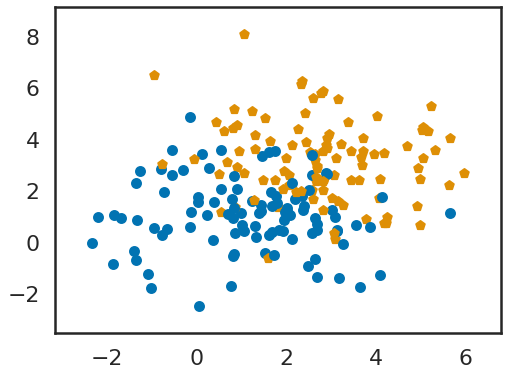

In [38]:
plot_2d(X1,y1)

## The perceptron

#### Linear classifiers (affine)

A **linear classifier** is a classifier associating to each observation $x$ a label in $\mathcal{Y}$ given its position related to an **affine hyperplane**. Each linear classifier is therefore linked to an affine hyperplan of $\mathbb{R}^p$, which we define by its **directing vector** (or normal vector) $\mathbf{w} = (w_0, w_1, ..., w_p) \in \mathbb{R}^p$. Note the supplementary dimension: it is used for what we call the *intercept* $w_0$ of the classifier (in French, *ordonnée à l'origine*). Geometrically, this allows the hyperplane to not go through the origin, and be shifted anywhere in the space. 
The hyperplane is then given by:
$$ H_{\mathbf{w}}=\left\{ \mathbf{x} \in \mathbb{R}^{p} : \hat{f}_{\mathbf{w}}(\mathbf{x}):=
w_0 +\sum_{j=1}^p w_j x_j=0 \right\}. $$

In order to classify an observation $\mathbf{x}$ (i.e, affect a label $1$ or $-1$, we use the function $sign(f(\mathbf{x}))$, where the $sign$ function is defined as:
$$ sign(x)=
\begin{cases}
 1,& \text{ si } x\geq0,\\
-1,& \text{ si } x<0
\end{cases}
\enspace . $$

Hence, the function  $\mathbf{x} \mapsto sign ( \hat{f}_{\mathbf{w}}(\mathbf{x}))$ is the binary classifier of linear separation defined by $\mathbf{w}$. The objective of the perceptron is to find an hyperplane which separates in the best possible way the data, into two groups. We would like to have, on each side of the hyperplane, labels separated into homogenous groups. The vector $\mathbf{w}$ is called a **weight vectors**. 

For the next questions, you should reuse the datasets you obtained previously.

3) What does the linear separation given by the perceptron in dimension $p=2$ ? See if you can find (visually) a good separation for your datasets. When is $\hat{f}_{\mathbf{w}}(\mathbf{x})$ large ? Negative ? Positive ? How can that function be interpreted geometrically ? What does $w_0$ corresponds to on the linear separation you found on your data ?

4) Check that the function ```predict(x,w)``` takes, as input, a vector $\mathbf{x} \in \mathbb{R}^p$ and a weight vector $\mathbf{w} \in \mathbb{R}^{p+1}$ and outputs the prediction $\hat{f}_{\mathbf{w}}(\mathbf{x})$. Then, check that ```predict_class(x,w)``` outputs the predicted label $sign\left(\hat{f}_\mathbf{w}(\mathbf{x})\right)$.

In [44]:
def predict(x, w):
    """Prediction from a normal vector."""
    return np.dot(x, w[1:]) + w[0]


def predict_class(x, w):
    """Predict a class from at point x thanks to a normal vector."""
    return np.sign(predict(x, w))

### Perceptron learning rule

The **perceptron algorithm** consists in detecting when there is a mistake, meaning that there is a point that is misclassified, and moving $\mathbf{w}$ towards having this point on the 'right side' of the hyperplane. The change in $\mathbf{w}$ for a case when the point is misclassified is described by the following learning rule (Rosenblatt's):
$$\mathbf{w}\leftarrow\mathbf{w}+\epsilon \begin{pmatrix}1 \\ \mathbf x_i \end{pmatrix}\cdot y_i$$
where $\epsilon$ is a *learning step*, which indicates how much we correct $\mathbf{w}$. The method is iterative: we will go through all examples we have in our data and update the points accordingly. 
Then, the algorithm is as follows:

- **Data**: 
    - The observations and their labels $\mathcal{D}_n=\{(\mathbf{x}_i,y_i): 1\leq i \leq n\}$
    - The gradient step: $\epsilon$
    - The maximal number of iterations: $n_{iter}$

- **Result**: 
    - $\mathbf{w}$ 
- Randomly initialize $\mathbf{w}$; initialize $j=0$
- While ${j\leq n_{\rm iter}}$ 
    - $\mathbf{w}\leftarrow\mathbf{w}$
    - For $i=1$ to $n$:
        - if $\hat{f}_{\mathbf{w}}(\mathbf{x}) \cdot y_i \leq 0$
            - $\mathbf{w}\leftarrow\mathbf{w}+\epsilon \begin{pmatrix}1 \\ \mathbf x_i \end{pmatrix}\cdot y_i$
        - $j\leftarrow j+1$
        
The code for this procedure is given in the ```perceptron``` function:

In [74]:
def perceptron(x, y, eps, niter, w_ini):
    """ algorithme du perceptron:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        """
    w = np.zeros((niter, w_ini.size))
    w[0] = w_ini
    for j in range(0, niter-1):
        for i in range(x.shape[0]):
            if y[i] * predict(x[i, :], w[j, :]) < 0:
                w[j, :] += eps * y[i] * np.hstack((np.ones((1,)), x[i, :]))
        w[j+1, :] = w[j, :] 
    return w

5) Test the perceptron algorithm on the following parameters and look at how $\mathbf{w}$ evolves during the iterations. 

In [49]:
# Choose an epsilon
epsilon = 0.2
# A number of iterations
niter = 10
# Initialize w_ini
std_ini = 1.
w_ini = std_ini * np.random.randn(X1.shape[1] + 1)

w1 = perceptron(X1, y1, epsilon, niter, w_ini)

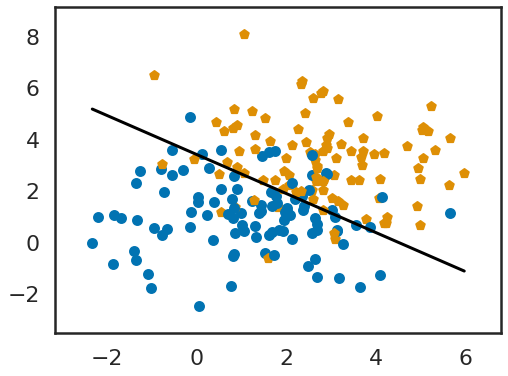

In [52]:
plot_2d(X1,y1,w1[-1,:])

6) Display on the same figure the evolution of the boundaries according to the iterations. We can use the ```plot_2d``` function and its ```alpha_choice``` argument for that purpose.

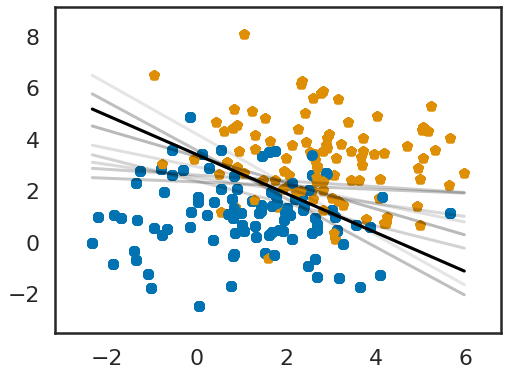

In [71]:
plt.figure()
alphas = np.linspace(0.1,0.3,9)
for idx, alpha in enumerate(alphas):
    plot_2d(X1, y1, w1[idx,:], alpha_choice=alpha)
    
plot_2d(X1, y1, w1[-1,:], alpha_choice=1)
plt.show()

### General case: cost function

While the perceptron algorithm we saw works geometrically, in general, in order to measure the error associated to an entire dataset $\mathcal{D}_n$ it is necessary to set a loss function $\ell:\mathbb{R}\times\mathcal{Y} \mapsto \mathbb{R}^+$ which measures the cost $h$ of an error $i$ when predicting an example.
The cost that we want to minimize (as a function of $\mathbf{w}$) is $\mathbb{E} \left[ \ell(\hat{f}_{\mathbf{w}}(\mathbf{x}),y)\right]$, the expectation of the loss function on all the data. Three loss functions are commonly used and defined below :
- the error percentage: $ZeroOneLoss(\hat{f}_{\mathbf{w}}(\mathbf{x}), y) = |y-sign(\hat{f}_{\mathbf{w}}(\mathbf{x}))|/2$,
- the quadratic error: $MSELoss(\hat{f}_{\mathbf{w}}(\mathbf{x}), y) = (y-\hat{f}_{\mathbf{w}}(\mathbf{x}))^2$,
- the hinge error (*charnière* in French): $HingeLoss(\hat{f}_{\mathbf{w}}(\mathbf{x}), y) = \max(0,1-y \cdot \hat{f}_{\mathbf{w}}(\mathbf{x}))$.
The purpose here is to study these different loss functions. These three functions are already implemented, as well as their associated gradient:

In [ ]:
def zero_one_loss(x, y, w):
    """0-1 loss function."""
    return abs(y - np.sign(predict(x, w))) / 2.

def hinge_loss(x, y, w):
    """Hinge loss function."""
    return np.maximum(0., 1. - y * predict(x, w))

def mse_loss(x, y, w):
    """Mean square error loss."""
    return (y - predict(x, w)) ** 2

def gr_hinge_loss(x, y, w):
    """Sub-gradient of the loss function hingeloss."""
    return np.dot(-y * (hinge_loss(x, y, w) > 0.),
                  np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_mse_loss(x, y, w):
    """Gradient of the least squares lost function."""
    return -2. * np.dot(y - predict(x, w),
                        np.hstack((np.ones((x.shape[0], 1)), x)))

7) Suppose that $\mathbf{x} \in \mathbb{R}^p$ and $y \in \mathbb{R}$ are fixed. What is the nature of the functions $\mathbf{w} \mapsto \ell(\hat{f}_{\mathbf{w}}(\mathbf{x}),y)$ for the three losses studied: constant, linear, quadratic, piecewise constant, linear, by pieces, quadratic by pieces, etc. ?

## Stochastic gradient descent algorithm

In the general case, it is of course impossible to do an exhaustive search of the space $\mathbb{R}^{p+1}$ where evolves $\mathbf{w}$ to minimize the gradient of $\mathbf{w} \mapsto \ell(\hat{f}_{\mathbf{w}}(\mathbf{x}),y)$ in order to find the minimum cost. Moreover, we cannot observe $\mathbb{E} \left[ \ell(\hat{f}_{\mathbf{w}}(\mathbf{x}),y)\right]$, so we can only try to **minimize its empirical counterpart**: $$\sum_{i=1}^n \ell(\hat{f}_{\mathbf{w}}(\mathbf{x}_i),y_i)$$


The **perceptron algorithm** actually consists in using a variant of the gradient descent algorithm, which is the usual method of optimizing a differentiable function. Here, at each step, the current weight is corrected in the same direction as the gradient, but in the opposite sense. The algorithm converges in the general case to a local minimum as long as $\epsilon$, which we now call the **gradient step** is well chosen. Moreover, the minimum reached is global for convex functions.

The stochastic gradient method is a variant which proposes not to directly use the gradient, which requires calculating a sum on the $n$ observations, but rather to draw (randomly ... or not) a pair $(\mathbf{x}_i , y_i )$ on which a gradient is calculated. We can also show that this algorithm converges under certain conditions.

The **perceptron algorithm** is now described as follows:

- **Data**: 
    - The observations and their labels $\mathcal{D}_n=\{(\mathbf{x}_i,y_i): 1\leq i \leq n\}$
    - The gradient step: $\epsilon$
    - The maximal number of iterations: $n_{iter}$

- **Result**: 
    - $\mathbf{w}$ 
- Randomly initialize $\mathbf{w}$; initialize $j=0$
- While ${j\leq n_{\rm iter}}$ 
    - $\mathbf{w}\leftarrow\mathbf{w}$
    - For $i=1$ to $n$:
        - $\mathbf{w}\leftarrow\mathbf{w}-\epsilon\nabla_\mathbf{w}\ell( \hat{f}_{\mathbf{w}}(\mathbf{x}_i, y_i))$
        - $j\leftarrow j+1$

The code for this procedure is given in the ```gradient``` function:

*Note: The stochastic gradient method is also available in ```sklearn``` under the name ```SGDClassify``` (SGD is the abbreviation for Stochastic Gradient Descent). A description is given on the page: http://scikit-learn.org/stable/modules/sgd.html.*

In [ ]:
def gradient(x, y, eps, niter, w_ini, loss_fun, gr_loss_fun, stochastic=True):
    """ algorithme de descente du gradient:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        - loss_fun : fonction de cout
        - gr_loss_fun : gradient de la fonction de cout
        - stoch : True : gradient stochastique
        """
    w = np.zeros((niter, w_ini.size))
    w[0] = w_ini
    loss = np.zeros(niter)
    loss[0] = loss_fun(x, y, w[0]).mean()
    for i in range(1, niter):
        if stochastic:  # this is for Stochastic Gradient Descent
            idx = [np.random.randint(x.shape[0])]
        else:           # this is for pure Gradient Descent
            idx = np.arange(x.shape[0])
        w[i, :] = w[i - 1, :] - eps * gr_loss_fun(x[idx, :],
                                                  y[idx], w[i - 1, :])
        loss[i] = loss_fun(x, y, w[i, :]).mean()
    return w, loss

7) The perceptron algorithm we first saw is equivalent to this more general one, with a specific loss function. Which one ? In this case, interpret the following condition: $\hat{f}_{\mathbf{w}}(\mathbf{x}_i)\cdot y_i \leq $0

8) Describe a pseudo-algorithm "Random perceptron", a modification that visits observations by making a uniform random draw (do the case with discount and without discount). It is this version which is generally called the Stochastic Gradient Descent. We do not ask you to implement this function here; indeed, this random version is the default one proposed in the ```gradient``` function.

9) We will graphically observe, with the function ```plot_gradient```, the evolution of $\frac{1}{n} \sum_{i=1}^n \ell(\hat{f}_{\mathbf{w}}(\mathbf{x}_i),y_i)$ according to $\mathbf{w}$ following the steps of the algorithm. Simple gradient descent is also called **batch**, and consists in calculating the true gradient $\frac{1}{n} \sum_{i=1}^n \nabla_{\mathbf{w}}\ell(\hat{f}_{\mathbf{w}}(\mathbf{x}_i),y_i)$. Launch the example with and without the stochastic option. Why should the number of iterations be ```niter * len(y)``` instead of ```niter``` in the stochastic case ? 

In [ ]:
def plot_gradient(X, y, wh, cost_hist, loss_fun):
    """ display 4 figures on how  (stochastic) gradient descent behaves
    wh : solution history
    cost_hist : cost history
    loss_fun : loss function
    """
    best = np.argmin(cost_hist)
    plt.subplot(221)
    plt.title('Data and hyperplane estimated')
    plot_2d(X, y, wh[best, :])
    plt.subplot(222)
    plt.title('Projection of level line and algorithm path')
    plot_cout(X, y, loss_fun, wh)
    plt.subplot(223)
    plt.title('Objective function vs iterations')
    plt.plot(range(cost_hist.shape[0]), cost_hist)
    plt.subplot(224, projection='3d')
    plt.title('Level line and algorithm path')
    plot_cout3d(X, y, loss_fun, wh)

In [ ]:
#############################################################################
#            Displaying tools for plot_gradient - no understanding needed ! #
#############################################################################

def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """Frontiere plotting for a decision function f."""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()

def frontiere_new(clf, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True, n_labels=3, n_neighbors=3):
    """Trace la frontiere pour la fonction de decision de clf."""
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    XX = np.c_[xx.ravel(), yy.ravel()]
    print(XX.shape)
    z = clf.predict(XX)
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    # color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    # sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)
    plt.title("L=" + str(n_labels) + ",k=" +
              str(n_neighbors))

def frontiere_3d(f, data, step=20):
    """Plot the 3d frontiere for the decision function f."""
    ax = plt.gca(projection='3d')
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    ax.plot_surface(xx, yy, z, rstride=1, cstride=1,
                    linewidth=0., antialiased=False,
                    cmap=plt.cm.coolwarm)

def plot_cout(X, y, loss_fun, w=None):
    """Plot the cost function encoded by loss_fun,

    Parameters
    ----------
    X : data features
    y :  labels
    loss_fun : loss function
    w : (optionnal) can be used to give a historic path of the weights """
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(X, y, ww).mean()
    datarange = np.array([[np.min(X[:, 0]), np.min(X[:, 1])],
                          [np.max(X[:, 0]), np.max(X[:, 1])]])
    frontiere(_inter, np.array(datarange))
    if w is not None:
        plt.plot(w[:, 1], w[:, 2], 'k')
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])

def plot_cout3d(x, y, loss_fun, w):
    """ trace le cout de la fonction cout loss_fun passee en parametre, en x,y,
        en faisant varier les coordonnees du poids w.
        W peut etre utilise pour passer un historique de poids"""
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(x, y, ww).mean()

    datarange = np.array([[w[:, 1].min(), w[:, 2].min()],
                         [w[:, 1].max(), w[:, 2].max()]])
    frontiere_3d(_inter, np.array(datarange))
    plt.plot(w[:, 1], w[:, 2], np.array([_inter(w[i, 1:]) for i in
             range(w.shape[0])]), 'k-', linewidth=3)

10) Experiment on different datasets: use either the cost functions provided here with ```gradient```,  either the ```sklearn``` function. Study performance according to the following points: the number of iterations, the cost function, the difficulty of the problem (whether the classes are easily separable or not, which you can act on by choosing different gaussian to generate from). Do you at any point observe strange behaviour ? If so, what is the reason?

11) Study as before the behavior of the gradient descent algorithm, but with the option ```stoch=True``` disabled.

12) Propose/code alternative stopping conditions for the algorithm.